In [1]:
RESOURCE: https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864

SyntaxError: invalid syntax (<ipython-input-1-dd0d7c3cd3f2>, line 1)

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as utils
from torch.optim import Adam

from torch.utils.data import DataLoader

from IPython.core.debugger import set_trace

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
from pathlib import Path
from IPython.display import display, Image

path = "data/"
train_path = path + 'train.csv'
test_path = path + 'test.csv'

In [6]:
PATH = Path.cwd()

In [7]:
for x in Path.iterdir(PATH/'data'):
    print(x)

/home/paperspace/gitProjects/DigitRecognizer/data/sample_submission.csv
/home/paperspace/gitProjects/DigitRecognizer/data/train.csv
/home/paperspace/gitProjects/DigitRecognizer/data/test.csv


In [8]:
##import CSV into pandas dataframe and convert to np array
test_data = pd.read_csv(PATH/'data/test.csv')
train_data = pd.read_csv(PATH/'data/train.csv')
test_np_data = test_data.values;
train_np_data = train_data.values;

In [ ]:
#turn a row of our data into a square image to be used by matplotlib
def getImg(img_in, h, w):
    #input is a 1D array (single row in our 2D np array representation of csv file)
    img_out = np.zeros(shape=(h,w))
    row = 0
    for x in range(1,h*w): #sine index 1 is the label
        col = x%w
        img_out[row][col] = img_in[x]
        if col == w-1:
            row = row + 1
    return img_out
            
def show_npimg(img):
    plt.imshow(img)
    plt.show()
    
def show_im(img, h=28,w=28):
    temp = getImg(img, h, w)
    show_npimg(temp)
    

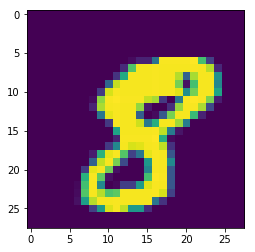

In [10]:
##show a single image
show_im(train_np_data[10])

In [11]:
#split train set for validation
val_split = 0.2
num_img = len(train_np_data)
idx = [range(0,num_img-1)]
val_idx = np.random.choice(idx,int(num_img*val_split),replace=True)
sorted(val_idx)

ValueError: a must be 1-dimensional

In [12]:
int(val_split*num_img)

8400

In [82]:
###Prepare data in Numpy
def get3D(data1D, h=28, w=28):
     #input is a 1D array (single row in our 2D np array representation of csv file)
     #output is a 3D tensor (channel,height,width)
    np_out = np.zeros(shape=(1,h,w))
    row = 0
    for x in range(1,h*w): #sine index 1 is the label
        col = x%w
        np_out[0][row][col] = data1D[x]
        if col == w-1:
            row = row + 1
    return np_out

def get4D(data2D, h=28, w=28):
    #input is 2D array (image number x pixel values)
    #output is 4D tensor (image number x channel x h x w)
    num_img = len(data2D)
    np_out = np.zeros(shape=(num_img, 1, h, w))
    for i in range(num_img):
        np_out[i] = get3D(data2D[i])
    return torch.from_numpy(np_out)
    

In [83]:
##create Dataset and Dataloader
#features needs to be 4D, where each index 0 is the image, index 1 is the channel, and 3/4 are h/w
#targets needs to be 1D, where each index represents an image
train_features = get4D(train_np_data)
train_targets = torch.from_numpy(train_np_data[:,0])
train_targets.size() , train_features.size()
trn_data = utils.TensorDataset(train_features, train_targets)
train_loader = utils.DataLoader(trn_data,batch_size=64,shuffle=True,num_workers=4)

In [14]:
#BnLayer class from FastAI -- 
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni,nf,kernel_size=kernel_size, stride=stride,
                            bias=False, padding=1)
        self.add = nn.Parameter(torch.zeros(nf,1,1))
        self.mult = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self,inp):
        x = F.relu(self.conv(inp))
        #don't understand how they are calculating the means
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds = x_chan.std(1)[:None,None]
        return (x-self.means)/self.stds * self.mult + self.add
    
#Resnet Layer from FastAI -- 
class ResnetLayer(BnLayer):
    def forward(self,inp): return inp + super().forward(inp)

In [15]:
#Resnet Model from FastAi --
class Resnet(nn.Module):
    """
    Takes in layers (list)  and c (int, number of classes) as input
    """
    def __init__(self,layers,c):
        set_trace()
        super(Resnet,self).__init__()
        #initial large Conv Layer (applied once)
        self.conv1 = nn.Conv2d(3,10,kernel_size=5, stride=1, padding=2)
        self.layers1 = nn.ModuleList([BnLayer(layers[i],layers[i+1])
            for i in range(len(layers)-1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1],layers[i+1],
            stride=1) for i in range(len(layers)-1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1],layers[i+1],
            stride=1) for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1],c)
        
    def forward(self,inp):
        x = self.conv1(inp)
        for l1,l2,l3 in zip(self.layers1, self.layers2, self.layers3):
            x = l3(l2(l1(x)))
        x = F.adaptive_max_pool2d(x,1)
        #don't get this
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)
        
    

In [16]:
print('Is GPU available?   :   ' + str(torch.cuda.is_available()))


Is GPU available?   :   True


In [84]:
layers = [10, 20, 40]
num_classes = 10
model=Resnet(layers, num_classes)
if torch.cuda.is_available():
    model.cuda()

> <ipython-input-15-7b3c1b2b8dd0>(8)__init__()
      6     def __init__(self,layers,c):
      7         set_trace()
----> 8         super(Resnet,self).__init__()
      9         #initial large Conv Layer (applied once)
     10         self.conv1 = nn.Conv2d(3,10,kernel_size=5, stride=1, padding=2)

ipdb> c


In [85]:
lr = 0.001
wd=0.001
loss_fn = nn.CrossEntropyLoss()
opt = Adam(model.parameters(),lr=lr, weight_decay=wd )


In [86]:
###KEY FUNCTIONS FOR TRAINING###

#FOO: change this to take in a list of lrs. annd adjust LR
#function to get a learning rate while training (using discrimative learning rates)
def get_lr_rate(epoch, num_epochs, init_lr=0.001, lr_div=10):
    lr = init_lr
    if epoch/num_epochs > 0.6:
        lr = lr/(lr_div*lr_div)
    elif epoch/num_epochs > 0.3:
        lr = lr/lr_div
    return lr

#function for saving models
def save_models(m,idx,fn='digit_rec_model_'):
    torch.save(m.state_dict(), f"{fn}{idx}")
    print("Model Saved")

In [87]:
###Training Function###
#def get_trn_loss(m,activations,labels):
      

#def get_val_acc(model,train):
    
def get_loss(act,targets):
    #computes loss for a given batch of activations (act) and target values (targets)
    criterion = nn.CrossEntropyLoss()
    return criterion(act,targets)
    
def predict(activs):
    _,predictions = torch.max(activs.data,1)
    return predictions

def train(m,num_epochs,init_lr=0.001):
    best_acc = 0.0
    
    for param_group in opt.param_groups:
        param_group["lr"] = init_lr
    
    for epoch in range(num_epochs):
        model.train() #set model to training mode
        acc = 0.0
        loss = 0.0
        for i, (images,gt) in enumerate(train_loader):
            if torch.cuda.is_available():
                images.cuda()
                gt.cuda()
            opt.zero_grad() #zero all gradients
            set_trace()
            outputs=model(images) #get output activations
            loss = get_loss(outputs,gt)
            loss.backward() #backprop loss
            opt.step() #change parameters
            
            tot_loss += loss.data[0]
            tot_acc += acc
            
        lr = get_lr_rate(epoch, num_epochs, init_lr)
        for param_group in opt.param_groups: 
            param_group["lr"] = lr

        acc = get_val_acc(m)
        
        if val_acc > best_acc:
            save_models(model,epoch)
        #show metrics for each epoch
        print("Epoch: {epoch}   TrnLoss: {loss}   ValAcc: {acc}")
        

In [88]:
train(model,1)

> <ipython-input-87-10515f4f4467>(32)train()
     30             opt.zero_grad() #zero all gradients
     31             set_trace()
---> 32             outputs=model(images) #get output activations
     33             loss = get_loss(outputs,gt)
     34             loss.backward() #backprop loss

ipdb> c


TypeError: argument 0 is not a Variable

In [65]:
loss = nn.CrossEntropyLoss()

In [45]:
input = torch.autograd.Variable(torch.randn((3,5)))
tgt = torch.autograd.Variable(torch.LongTensor(3).random_(5))

In [50]:
out = loss(input,tgt)

In [49]:
loss

CrossEntropyLoss(
)

In [58]:
out.data[0]

1.9108232259750366